## Comparing Strain Sensor ADC to Autobender/Rotary Encoder

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from config import path_to_repository
from analysis import DLC3DBendAngles
from analysis import bender_class
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")

h_renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_12_18_44_H/data_rotenc_2025_09_09_12_18_44.csv")
h_strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_12_18_44_H/data_adc_2025_09_09_12_18_44.csv")

# --- load CSVs ---
strain_df = pd.read_csv(strain)
renc_df   = pd.read_csv(renc)

h_strain_df = pd.read_csv(h_strain)
h_renc_df   = pd.read_csv(h_renc)



In [7]:
strain_df

,timestamp,adc_ch0,adc_ch1,adc_ch2,adc_ch3
0,114843652923,0,0,0,13055070
1,114843652923,0,0,0,13057801
2,114843652923,0,0,0,13043807
3,114843652923,1332,0,0,13053876
4,114843652923,0,0,0,13057289
...,...,...,...,...,...
6945,114853651709,0,0,0,12510823
6946,114853651709,0,0,0,12519015
6947,114853651709,0,0,0,12513042
6948,114853651709,0,0,0,12509970


In [8]:
cam = DLC3DBendAngles(strain_df)
h_cam = DLC3DBendAngles(h_strain_df)


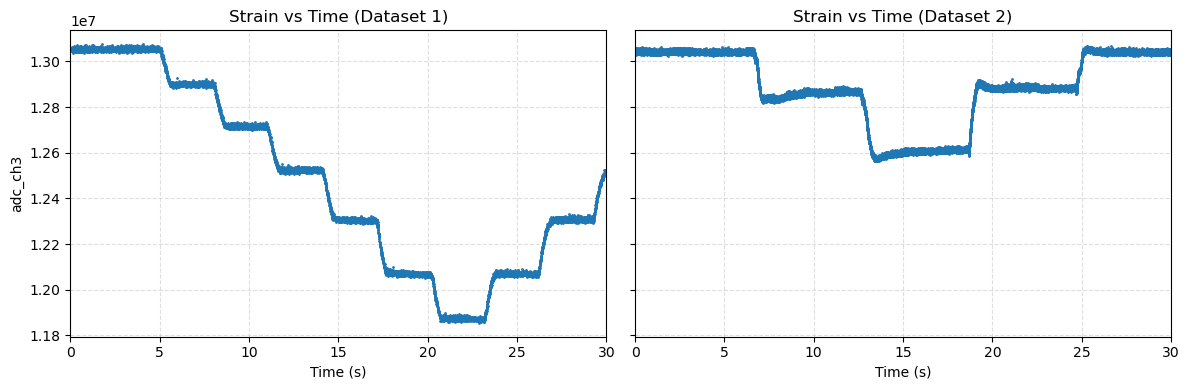

Plotted y columns: dataset1='adc_ch3', dataset2='adc_ch3'


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pick a y/strain column (tweak the preference list as needed)
def pick_ycol(df, prefer=("adc_ch3", "ADC Value", "adc", "strain", "Strain")):
    for c in prefer:
        if c in df.columns:
            return c
    # fallback: first numeric column
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    raise KeyError("No numeric column found for y.")

# choose columns
ycol1 = pick_ycol(strain_df)
ycol2 = pick_ycol(h_strain_df)

# y values
y1 = pd.to_numeric(strain_df[ycol1], errors="coerce").to_numpy(dtype=float)
y2 = pd.to_numeric(h_strain_df[ycol2], errors="coerce").to_numpy(dtype=float)

# time axes: first = 0 s, last = 30 s
t1 = np.linspace(0.0, 30.0, y1.size)  # endpoint=True by default, so last point is exactly 30
t2 = np.linspace(0.0, 30.0, y2.size)

# finite masks
m1 = np.isfinite(y1)
m2 = np.isfinite(y2)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].plot(t1[m1], y1[m1], ".", markersize=2)
axes[0].set_title("Strain vs Time (Dataset 1)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel(ycol1)
axes[0].grid(True, linestyle="--", alpha=0.4)
axes[0].set_xlim(0, 30)

axes[1].plot(t2[m2], y2[m2], ".", markersize=2)
axes[1].set_title("Strain vs Time (Dataset 2)")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True, linestyle="--", alpha=0.4)
axes[1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

print(f"Plotted y columns: dataset1='{ycol1}', dataset2='{ycol2}'")


In [10]:
# sensor on just autobender

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
cam.find_matching_indices(
    encoder_df=renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
merged_df = cam.attach_encoder_using_match(
    encoder_df=renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)

# The merged, time-aligned dataframe is now in cam.df (and also returned as merged_df)
print("Aligned rows:", len(merged_df))
print(merged_df.filter(regex="timestamp|angle|strain|time_delta", axis=1).head())


# hand calibration with autobender

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
h_cam.find_matching_indices(
    encoder_df=h_renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
h_merged_df = h_cam.attach_encoder_using_match(
    encoder_df=h_renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)

# The merged, time-aligned dataframe is now in cam.df (and also returned as merged_df)
print("Aligned rows:", len(h_merged_df))
print(h_merged_df.filter(regex="timestamp|angle|strain|time_delta", axis=1).head())



[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 11:48:43.652923 → 0 days 11:48:53.651709
[debug] enc range: 0 days 11:48:43.666324 → 0 days 11:48:53.643426
[debug] probe |delta| (ms) stats: count    21.000000
mean      6.750333
std       3.395231
min       0.376000
25%       4.194000
50%       7.479000
75%       9.427000
max      13.401000
Name: delta_ms, dtype: float64
Aligned rows: 6505
      timestamp  timestamp_renc  angle_renc  time_delta_renc
5  114843674580    114843666324   -2.455342           -8.256
6  114843674580    114843666324   -2.455342           -8.256
7  114843674580    114843666324   -2.455342           -8.256
8  114843674580    114843666324   -2.455342           -8.256
9  114843674580    114843666324   -2.455342           -8.256


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:593: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:594: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 12:18:46.342516 → 0 days 12:19:16.335135
[debug] enc range: 0 days 12:18:46.348692 → 0 days 12:19:08.503619
[debug] probe |delta| (ms) stats: count      21.000000
mean     1171.304286
std      2348.591779
min         2.256000
25%         6.597000
50%         7.642000
75%       344.291000
max      7824.069000
Name: delta_ms, dtype: float64
Aligned rows: 14270
      timestamp  timestamp_renc  angle_renc  time_delta_renc
0  121846342516    121846348692   -3.390454            6.176
1  121846342516    121846348692   -3.390454            6.176
2  121846342516    121846348692   -3.390454            6.176
3  121846342516    121846348692   -3.390454            6.176
4  121846342516    121846348692   -3.390454            6.176


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:593: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:594: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


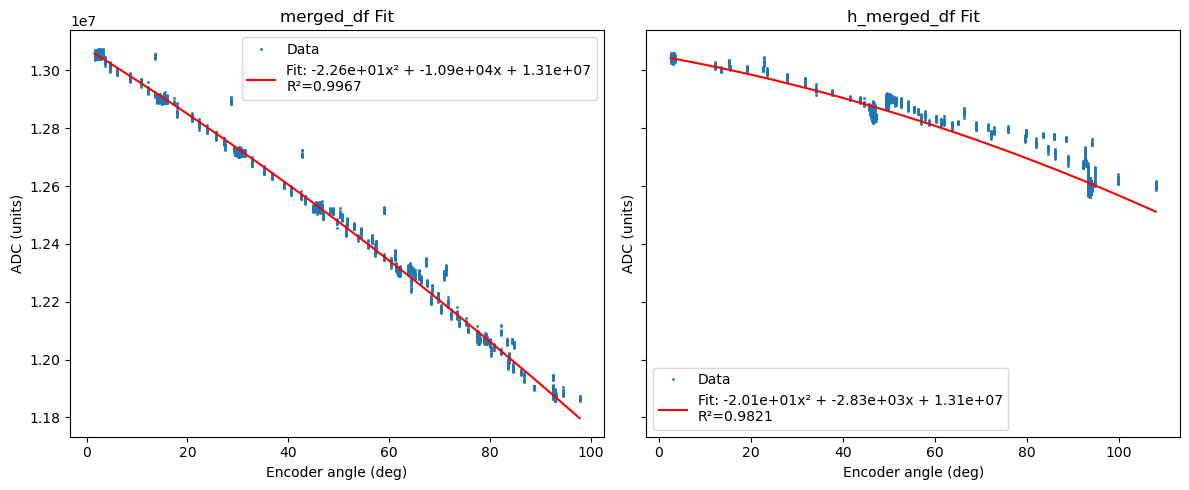

In [11]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Quadratic model
def quad_model(x, a, b, c):
    return a*x**2 + b*x + c

def fit_and_plot(ax, df, title):
    # Clean data
    x = pd.to_numeric(-df["angle_renc"], errors="coerce")
    y = pd.to_numeric(df["adc_ch3"], errors="coerce")
    mask = x.notna() & y.notna()
    x = x[mask].to_numpy()
    y = y[mask].to_numpy()

    # Fit
    params, cov = curve_fit(quad_model, x, y)
    a, b, c = params

    # Predictions
    y_pred = quad_model(x, a, b, c)

    # R² calculation
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Smooth fit curve
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = quad_model(x_fit, a, b, c)

    # Plot
    ax.plot(x, y, ".", markersize=2, label="Data")
    ax.plot(x_fit, y_fit, "r-", 
            label=f"Fit: {a:.2e}x² + {b:.2e}x + {c:.2e}\nR²={r2:.4f}")
    ax.set_xlabel("Encoder angle (deg)")
    ax.set_ylabel("ADC (units)")
    ax.set_title(title)
    ax.legend()

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fit_and_plot(axes[0], merged_df, "merged_df Fit")
fit_and_plot(axes[1], h_merged_df, "h_merged_df Fit")

plt.tight_layout()
plt.show()



In [12]:
# sensor on autobender

g = bender_class()

# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")

# Sensor on hand on autobender

h = bender_class()

# direct from aligned DataFrame
h.load_merged_df(h_merged_df, enc_col="angle_renc", adc_col="adc_ch3")




Loaded merged_df with 6505 rows into bender_class.
Loaded merged_df with 14270 rows into bender_class.


,Rotary Encoder,ADC Value,C3,C4
0,-3.390454,13038687,0,0
1,-3.390454,13035956,0,0
2,-3.390454,13039028,0,0
3,-3.390454,13036127,0,0
4,-3.390454,13034761,0,0
...,...,...,...,...
15455,-49.811272,12887137,0,0
15456,-49.811272,12896694,0,0
15457,-49.811272,12888161,0,0
15458,-49.811272,12893110,0,0


ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0


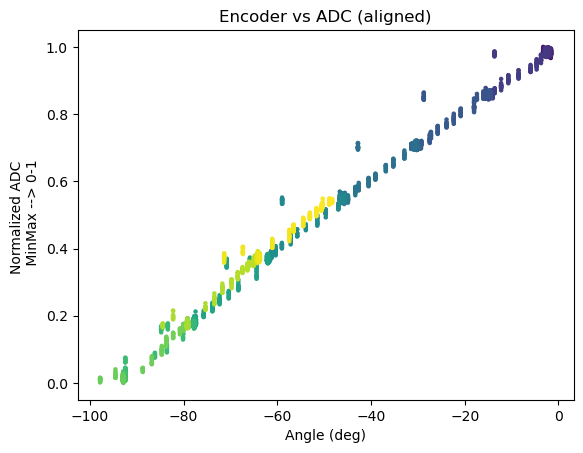

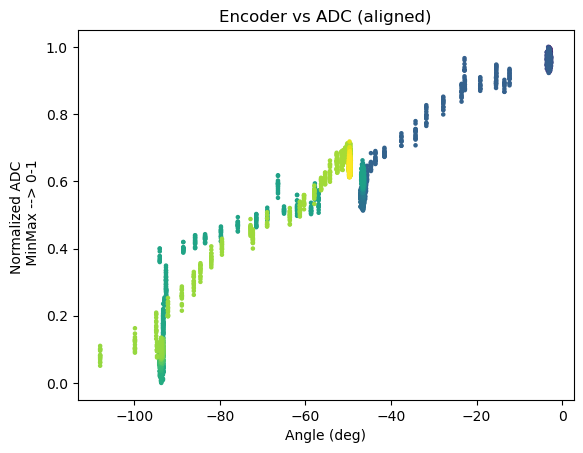

In [13]:
# sensor on autobnder
g.normalize_adc_bw_01()
g.plot_data(scatter=True, title="Encoder vs ADC (aligned)")

#sensor on hand on autobender

# now reuse existing methods
h.normalize_adc_bw_01()
h.plot_data(scatter=True, title="Encoder vs ADC (aligned)")



No angle threshold reaches 100% accuracy.
No angle threshold reaches 100% accuracy.
No angle threshold reaches 100% accuracy.


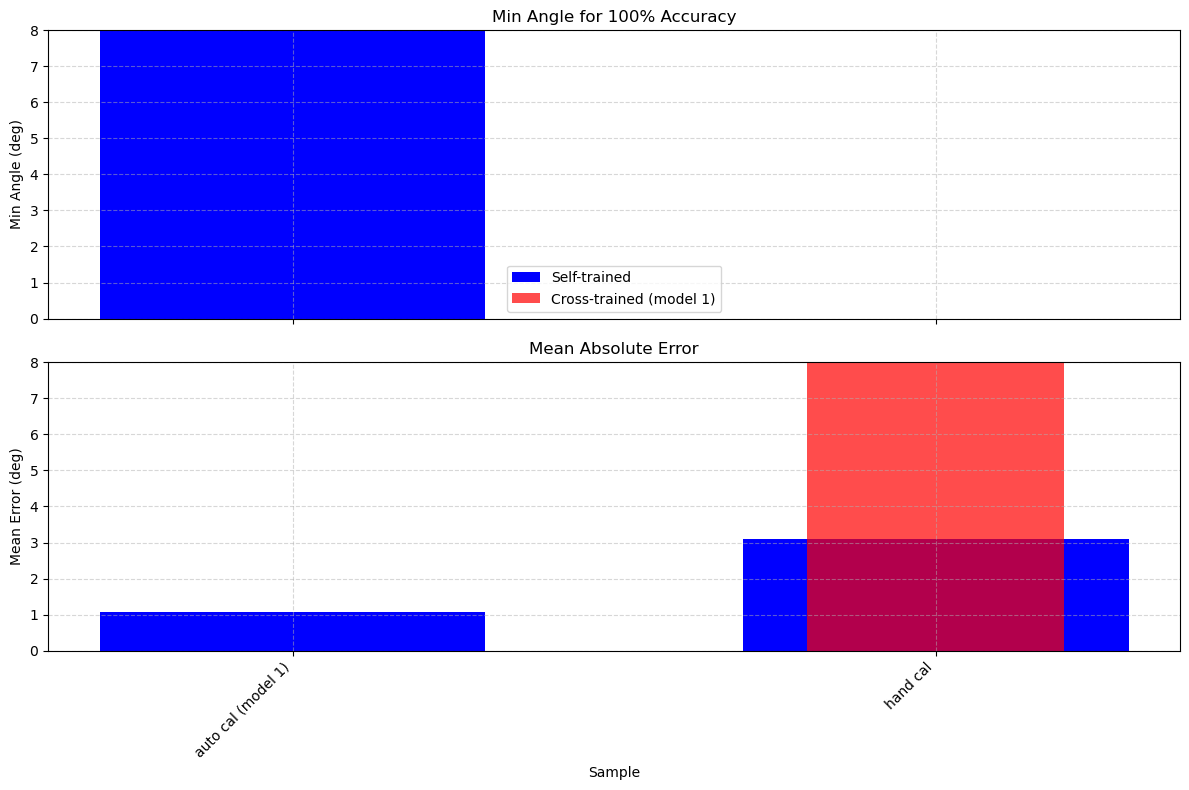

In [14]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

# --- helpers to find your columns (works with 'angle_renc' or 'angle_renc_renc', etc.) ---
def pick_angle_col(df):
    cols = df.columns
    renc_candidates = [c for c in cols if re.search(r'angle.*_renc$', c)]
    if renc_candidates:
        return renc_candidates[0]
    for cand in ("angle_renc", "angle", "enc_angle"):
        if cand in cols: return cand
    raise KeyError(f"No encoder angle column found in: {list(cols)}")

def pick_adc_col(df):
    for cand in ("adc_ch3","adc_ch2","adc_ch1","adc_ch0","adc","ADC Value"):
        if cand in df.columns: return cand
    m = [c for c in df.columns if re.match(r'adc_ch\d+', c)]
    if m: return m[0]
    raise KeyError(f"No ADC column found in: {list(df.columns)}")

# --- adapter: build a bender_class from an already-normalized DataFrame ---
def bender_from_normalized_df(df,
                              enc_col=None,
                              adc_col=None,
                              invert_angle=False,
                              normalize_label="pre-normalized"):
    enc_col = enc_col or pick_angle_col(df)
    adc_col = adc_col or pick_adc_col(df)

    # Build the 2 columns bender_class expects
    enc = np.asarray(df[enc_col], dtype=float)
    if invert_angle:
        enc = -enc
    adc = np.asarray(df[adc_col], dtype=float)

    # Create instance and inject data directly
    m = bender_class()
    m.data = pd.DataFrame({
        "Rotary Encoder": enc,    # degrees
        "ADC Value":      adc     # already normalized to your liking
    })
    m.columns = m.data.columns
    m.adc_normalized = True              # <- critical
    m.normalize_type = normalize_label   # purely for axis label/legend
    return m

# ---------------------------------------
# YOUR EXISTING STRUCTURE (no load/normalize)
# ---------------------------------------
# Inputs:
DS_all = [[merged_df], [h_merged_df]]
bar_labels = ["auto cal", "hand cal"]
degree = 15 

# Flatten datasets + labels
DS_flat = []; xlabel_flat = []
for ds_group, ds_lab in zip(DS_all, bar_labels):
    xlabel_flat.extend([ds_lab]*len(ds_group))
    DS_flat.extend(ds_group)

pairwise_min_accuracy = np.full((len(DS_flat), len(DS_flat)), np.nan)
pairwise_abs_error    = np.full((len(DS_flat), len(DS_flat)), np.nan)

for i, train_df in enumerate(DS_flat):
    train_name = f"DS{i+1}"

    # Build model directly from the pre-normalized DataFrame
    g = bender_from_normalized_df(train_df, normalize_label="pre-normalized (user)")
    # High-capacity fit on ~all train data (same as your old perc_train=0.99, niter=1)
    g.train_model_test_accuracy(perc_train=0.99, niter=1, degree=degree)

    for j, test_df in enumerate(DS_flat):
        if i == j:
            # Diagonal: within-sample CV with separate instance
            g2 = bender_from_normalized_df(train_df, normalize_label="pre-normalized (user)")
            # Your original used degree=2 here; keep that if intended:
            g2.train_model_test_accuracy(perc_train=0.8, niter=10, degree=2)

            min_angle_100, all_min_angle_100 = g.get_min_accuracy_100()
            if all_min_angle_100:
                pairwise_min_accuracy[i, j] = float(np.mean(np.array(all_min_angle_100)))
            if hasattr(g2, "abs_angular_error") and len(g2.abs_angular_error):
                pairwise_abs_error[i, j] = float(np.mean(np.hstack(g2.abs_angular_error)))
        else:
            # Off-diagonal: predict on held-out slices from the OTHER dataset
            g_test = bender_from_normalized_df(test_df, normalize_label="pre-normalized (user)")
            df_test = g_test.data

            acc_runs, err_runs = [], []
            for seed in range(10):
                _, df_te = train_test_split(df_test, test_size=0.2, shuffle=True, random_state=seed)
                accuracy, abs_error = g.predict_new_data(df_te)
                acc_runs.append(accuracy)
                err_runs.append(abs_error)

            if acc_runs:
                acc_mat = np.vstack(acc_runs)
                min_angle_100, all_min_angle_100 = g.get_min_accuracy_100(accuracy_matrix=acc_mat) or (np.nan, None)
                if all_min_angle_100:
                    pairwise_min_accuracy[i, j] = float(np.mean(np.array(all_min_angle_100)))
            if err_runs:
                pairwise_abs_error[i, j] = float(np.mean(np.hstack(err_runs)))

# ---------------------------------------------------
# PLOT using your class method (any instance works)
# ---------------------------------------------------
m = bender_class()
m.plot_compact_pairwise_comparison(
    pairwise_min_accuracy,
    pairwise_abs_error,
    xlabel_flat,
    group_size=2,   # 2 datasets
    ylim=(0, 8)
)


##  Master Plotting Attempt, combine autobender raw data with hand cal adjusted (where three angles worth of data selected), re do norm plot and error calc where new model on both data is used to predict just the hand cal data.  



Loaded merged_df with 6505 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.3253 in  (95% CI: 0.3210, 0.3296),  R²=0.9927


,timestamp,adc_ch0,adc_ch1,adc_ch2,adc_ch3,timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
5,114843674580,0,0,0,13055241,114843666324,14243,2.670562,-2.455342,-8.256
6,114843674580,0,0,0,13048585,114843666324,14243,2.670562,-2.455342,-8.256
7,114843674580,0,0,0,13049097,114843666324,14243,2.670562,-2.455342,-8.256
8,114843674580,0,0,0,13051487,114843666324,14243,2.670562,-2.455342,-8.256
9,114843674580,0,0,0,13055753,114843666324,14243,2.670562,-2.455342,-8.256
...,...,...,...,...,...,...,...,...,...,...
6945,114853651709,0,0,0,12510823,114853643426,10270,1.925625,-48.322019,-8.283
6946,114853651709,0,0,0,12519015,114853643426,10270,1.925625,-48.322019,-8.283
6947,114853651709,0,0,0,12513042,114853643426,10270,1.925625,-48.322019,-8.283
6948,114853651709,0,0,0,12509970,114853643426,10270,1.925625,-48.322019,-8.283


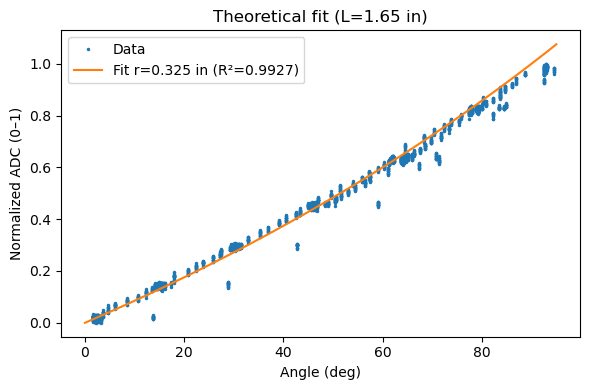

In [46]:
g = bender_class()


# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")
# now reuse existing methods
g.normalize_adc_bw_01()

res = g.fit_knuckle_radius_from_normalized(L=1.65, r0=0.5, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")
R_fit = res['r_hat']   # e.g. 0.40 in




In [17]:
h.data

,Rotary Encoder,ADC Value,C3,C4
0,-3.390454,0.953926,0,0
1,-3.390454,0.948465,0,0
2,-3.390454,0.954608,0,0
3,-3.390454,0.948807,0,0
4,-3.390454,0.946075,0,0
...,...,...,...,...
15455,-49.811272,0.650853,0,0
15456,-49.811272,0.669966,0,0
15457,-49.811272,0.652901,0,0
15458,-49.811272,0.662798,0,0


Estimated radius r ≈ 0.5300 in  (95% CI: 0.5209, 0.5391),  R²=0.9167


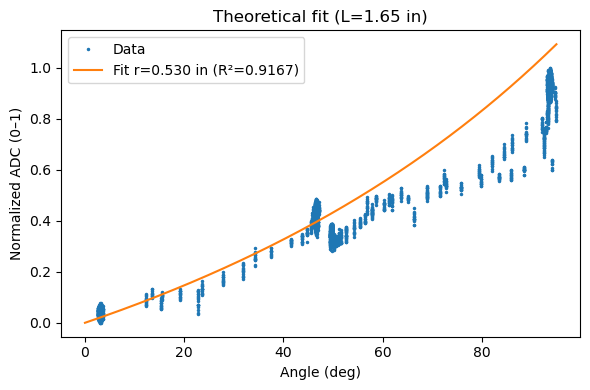

In [18]:
res = h.fit_knuckle_radius_from_normalized(L=1.65, r0=0.3, restrict_to_0_90=True, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")
R_ref = res['r_hat']   # e.g. 0.20 in


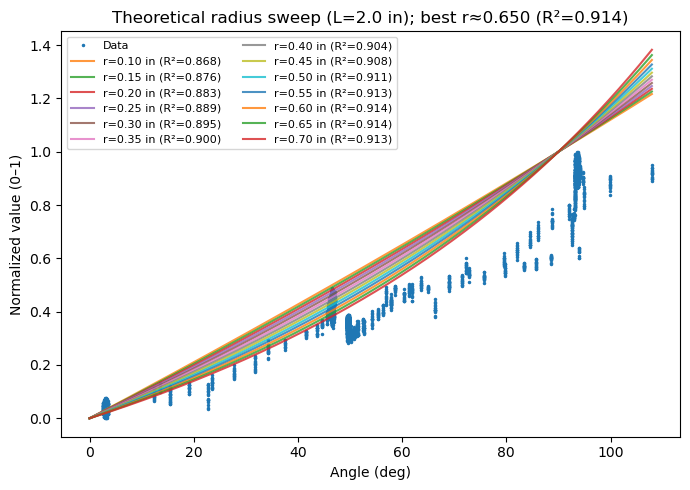

r (in)  |  R²
  0.65 |  0.9142  <= best
  0.60 |  0.9141
  0.70 |  0.9133
  0.55 |  0.9130
  0.50 |  0.9110
  0.45 |  0.9081
  0.40 |  0.9045
  0.35 |  0.9000
  0.30 |  0.8949
  0.25 |  0.8891
  0.20 |  0.8826
  0.15 |  0.8756
  0.10 |  0.8680
Best-by-visual-sweep: 0.65 in


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def _y_model(theta_rad, r, L=2.0):
    """Normalized theory (y=1 at 90°)."""
    a = r / L
    num = theta_rad * (8.0 - a*theta_rad)
    den = (2.0 - a*theta_rad)**2
    th90 = np.pi/2
    num90 = th90 * (8.0 - a*th90) / (2.0 - a*th90)**2
    return (num/den) / num90

def plot_radius_sweep(h,
                      L=2.0,
                      r_min=0.20, r_max=0.80, r_step=0.05,
                      angle_col="angle_renc",
                      value_col="ADC Value",  # <-- your normalized column name
                      restrict_to_0_90=True,
                      make_angles_positive=True,
                      flip_data=False):
    """
    Overlays theoretical curves for a sweep of r and reports R² vs the normalized data.
    Assumes h.data[value_col] is already normalized to 0–1 in the same sense as the model.
    """
    df = h.data.copy()
    x_deg = pd.to_numeric(df[angle_col], errors="coerce").to_numpy()
    y     = pd.to_numeric(df[value_col], errors="coerce").to_numpy()

    if flip_data:
        y = 1.0 - y
    if make_angles_positive:
        x_deg = np.abs(x_deg)
    if restrict_to_0_90:
        m = (x_deg >= 0) & (x_deg <= 90) & np.isfinite(y)
        x_deg, y = x_deg[m], y[m]
    else:
        m = np.isfinite(x_deg) & np.isfinite(y)
        x_deg, y = x_deg[m], y[m]

    if x_deg.size < 5:
        raise ValueError("Not enough points in the chosen angle window.")

    theta = np.deg2rad(x_deg)

    # grid for smooth theory curves
    theta_fit = np.deg2rad(np.linspace(0, max(90, x_deg.max()), 600))

    # sweep radii
    radii = np.round(np.arange(r_min, r_max + 1e-9, r_step), 3)
    scores = []

    plt.figure(figsize=(7, 5))
    # plot data
    plt.plot(x_deg, y, ".", markersize=3, label="Data")

    # compute R² per candidate and overlay
    best_r, best_r2 = None, -np.inf
    for r in radii:
        y_pred = _y_model(theta, r, L)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - y.mean())**2)
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
        scores.append((r, r2))

        # smooth curve
        y_fit = _y_model(theta_fit, r, L)
        lbl = f"r={r:.2f} in (R²={r2:.3f})"
        plt.plot(np.rad2deg(theta_fit), y_fit, "-", alpha=0.8, label=lbl)

        if r2 > best_r2:
            best_r2, best_r = r2, r

    plt.xlabel("Angle (deg)")
    plt.ylabel("Normalized value (0–1)")
    plt.title(f"Theoretical radius sweep (L={L} in); best r≈{best_r:.3f} (R²={best_r2:.3f})")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

    # print a compact table
    scores_sorted = sorted(scores, key=lambda t: -t[1] if np.isfinite(t[1]) else -np.inf)
    print("r (in)  |  R²")
    for r, r2 in scores_sorted:
        star = "  <= best" if r == best_r else ""
        print(f"{r:6.2f} | {r2: .4f}{star}")

    return {"best_r": best_r, "best_r2": best_r2, "scores": scores_sorted}

# After your fit:
# res = h.fit_knuckle_radius_from_normalized(...); R_ref = res['r_hat']

out = plot_radius_sweep(
    h,
    L=2.0,
    r_min=0.1,
    r_max=R_ref + 0.20,
    r_step=0.05,
    angle_col="Rotary Encoder",
    value_col="ADC Value",  # <-- ensure this is your normalized column in h.data
    restrict_to_0_90=False,
    make_angles_positive=True,
    flip_data=True
)
print("Best-by-visual-sweep:", out["best_r"], "in")



In [20]:
#rescale autobender data 

scale_factor = R_ref / R_fit  # hand / autobender


# Assuming g.data["angle_renc"] is your angle column in degrees or radians

# Make a rescaled-angle column (same units in/out: if enc_col was degrees, this stays degrees)
#g.data["Rotary Encoder"] = g.data["Rotary Encoder"] * scale_factor
#g.data["ADC Value"] = g.data["ADC Value"] * scale_factor

# thought!  Use autobender as master, and divide predicted angle of atuobnnder by ratio of radius predicted by autobender to Radius of knuckle by scale factor given mcp bend radius.  
#  knuckle should likely bend less

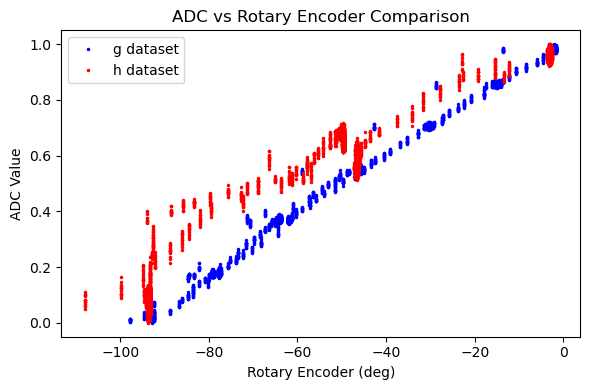

In [21]:


plt.figure(figsize=(6,4))

# Plot g.data
plt.plot(
    g.data["Rotary Encoder"], 
    g.data["ADC Value"], 
    ".", markersize=3, color="blue", label="g dataset"
)

# Plot h.data
plt.plot(
    h.data["Rotary Encoder"], 
    h.data["ADC Value"], 
    ".", markersize=3, color="red", label="h dataset"
)

plt.xlabel("Rotary Encoder (deg)")
plt.ylabel("ADC Value")
plt.title("ADC vs Rotary Encoder Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# theta predicted just dependent on R of MCP knuckle, which can either be measured or inferred from hand calibration.  

h.append_theta_from_normalized(
    r_hand=0.65,
    L=2.0,
    value_col="ADC Value",
    out_col="theta_pred_deg",
    flip_data=True,     # set True if your normalization is reversed
    tol_deg=1e-3,
    max_iters=30
)

0         6.765862
1         7.537651
2         6.668358
3         7.489586
4         7.874107
           ...    
15455    42.337532
15456    40.452003
15457    42.137032
15458    41.163368
15459    42.404137
Name: theta_pred_deg, Length: 14270, dtype: float64

In [23]:
h.data

,Rotary Encoder,ADC Value,C3,C4,theta_pred_deg
0,-3.390454,0.953926,0,0,6.765862
1,-3.390454,0.948465,0,0,7.537651
2,-3.390454,0.954608,0,0,6.668358
3,-3.390454,0.948807,0,0,7.489586
4,-3.390454,0.946075,0,0,7.874107
...,...,...,...,...,...
15455,-49.811272,0.650853,0,0,42.337532
15456,-49.811272,0.669966,0,0,40.452003
15457,-49.811272,0.652901,0,0,42.137032
15458,-49.811272,0.662798,0,0,41.163368


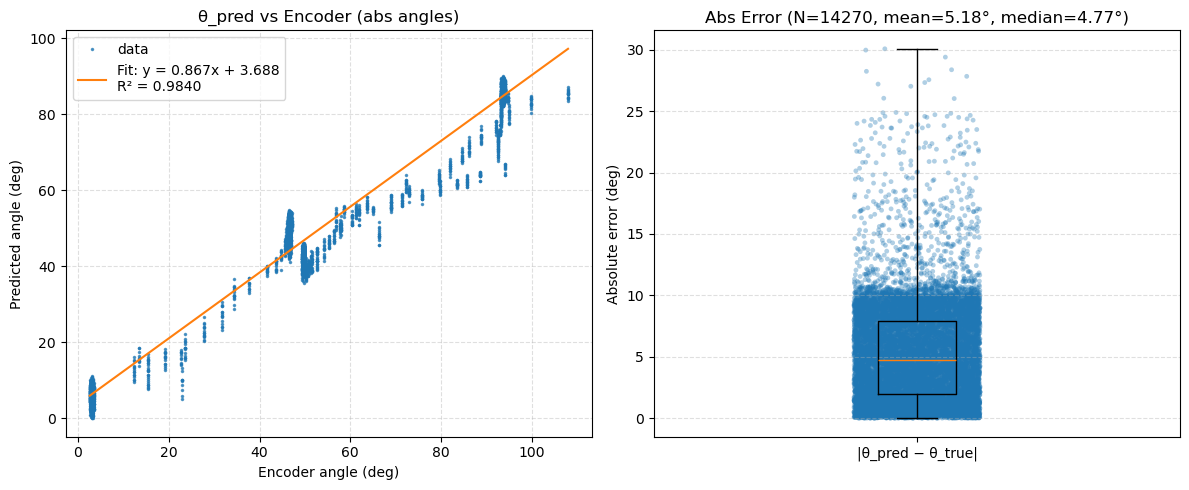

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- params you can tweak ---
jitter_width = 0.12   # horizontal jitter half-width (x in [1-j, 1+j])
jitter_alpha = 0.35   # transparency of jittered points
jitter_size  = 12     # marker size for jittered points

df = h.data.copy()

x_true = pd.to_numeric(df["Rotary Encoder"], errors="coerce").abs()
y_pred = pd.to_numeric(df["theta_pred_deg"], errors="coerce").abs()

mask = np.isfinite(x_true) & np.isfinite(y_pred)
x = x_true[mask].to_numpy()
y = y_pred[mask].to_numpy()

# linear fit (left panel)
p = np.polyfit(x, y, 1)
y_hat = np.polyval(p, x)
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

# absolute error
abs_err = np.abs(y - x)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Left: data + linear fit ----
ax = axes[0]
ax.plot(x, y, ".", markersize=3, label="data", alpha=0.7)
xs = np.linspace(x.min(), x.max(), 200)
ax.plot(xs, np.polyval(p, xs), "-",
        label=f"Fit: y = {p[0]:.3f}x + {p[1]:.3f}\nR² = {r2:.4f}")
ax.set_xlabel("Encoder angle (deg)")
ax.set_ylabel("Predicted angle (deg)")
ax.set_title("θ_pred vs Encoder (abs angles)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

# ---- Right: box plot + jittered points ----
axes[1].boxplot(abs_err, vert=True, whis=(0, 100), showfliers=False)
axes[1].set_xticks([1])
axes[1].set_xticklabels(["|θ_pred − θ_true|"])
axes[1].set_ylabel("Absolute error (deg)")
axes[1].set_title(
    f"Abs Error (N={abs_err.size}, mean={abs_err.mean():.2f}°, median={np.median(abs_err):.2f}°)"
)
axes[1].grid(True, axis="y", linestyle="--", alpha=0.4)

# Jittered scatter overlay
n = abs_err.size
xj = 1.0 + np.random.uniform(-jitter_width, jitter_width, size=n)  # uniform jitter around x=1
axes[1].scatter(xj, abs_err, s=jitter_size, alpha=jitter_alpha, edgecolors="none")

plt.tight_layout()
plt.show()
